# Basic cartoframes usage

`cartoframes` lets you use CARTO in a Python environment so that you can do all of your analysis and mapping in, for example, a Jupyter notebook. `cartoframes` allows you to use CARTO's functionality for data analysis, storage, location services like routing and geocoding, and visualization.

You can view this notebook best on `nbviewer` here: <https://nbviewer.jupyter.org/github/CartoDB/cartoframes/blob/master/examples/Basic%20Usage.ipynb>
It is recommended to download this notebook and use on your computer instead so you can more easily explore the functionality of `cartoframes`.

To get started, let's load the required packages, and set credentials.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartoframes
from cartoframes import Credentials
import pandas as pd

USERNAME = 'eschbacher'  # <-- replace with your username 
APIKEY = 'abcdefg'       # <-- your CARTO API key
creds = Credentials(username=USERNAME, 
                    key=APIKEY)
cc = cartoframes.CartoContext(creds=creds)

## `cc.read`

`CartoContext` has several methods for interacting with [CARTO](https://carto.com) in a Python environment. `CartoContext.read` allows you to pull a dataset stored on CARTO into a [pandas](http://pandas.pydata.org/) DataFrame. In the cell below, we use `read_taxi` to get the table `brooklyn_poverty` from a CARTO account.

In [2]:
from cartoframes.examples import read_brooklyn_poverty
cc.write(read_brooklyn_poverty(), 'brooklyn_poverty_example', overwrite=True)

Table successfully written to CARTO: https://eschbacher.carto.com/dataset/brooklyn_poverty_example


In [3]:
# Get a CARTO table as a pandas DataFrame
df = cc.read('brooklyn_poverty_example')
df.head()

,commuters_16_over_2011_2015,geoid,pop_determined_poverty_status_2011_2015,poverty_count,poverty_per_pop,the_geom,total_pop_2011_2015,total_population,walked_to_work_2011_2015_per_pop
cartodb_id,,,,,,,,,
1606,0.0,360470702031,0.0,NaN,NaN,0106000020E61000000800000001030000000100000013...,0.0,0,NaN
2052,NaN,360479901000,NaN,NaN,NaN,None,NaN,0,NaN
111,0.0,360470666001,0.0,NaN,NaN,0106000020E6100000030000000103000000010000006B...,0.0,0,1.553393e-12
116,NaN,360470702030,NaN,NaN,NaN,None,NaN,0,NaN
91,15928.0,360470080002,31367.0,225.0,0.17201,0106000020E61000000100000001030000000100000007...,39471.0,1309,1.505213e-02


Notice that:

* the index of the DataFrame is the same as the index of the CARTO table (`cartodb_id`)
* `the_geom` column stores the geometry. This can be decoded if we set the `decode_geom=True` flag in `cc.read`, which requires the library `shapely`.
* We have several numeric columns
* SQL `null` values are represented as `numpy.nan`

Other things to notice:

In [4]:
df.dtypes

commuters_16_over_2011_2015                float64
geoid                                       object
pop_determined_poverty_status_2011_2015    float64
poverty_count                              float64
poverty_per_pop                            float64
the_geom                                    object
total_pop_2011_2015                        float64
total_population                             int64
walked_to_work_2011_2015_per_pop           float64
dtype: object

The `dtype` of each column is a mapping of the column type on CARTO. For example, `numeric` will map to `float64`, `text` will map to `object` (pandas string representation), `timestamp` will map to `datetime64[ns]`, etc. The reverse happens if a DataFrame is sent to CARTO.

## `cc.map`

Now that we can inspect the data, we can map it to see how the values change over the geography. We can use the `cc.map` method for this purpose.

`cc.map` takes a `layers` argument which specifies the data layers that are to be visualized. They can be imported from `cartoframes` as below.

There are different types of layers:

* `Layer` for visualizing CARTO tables
* `QueryLayer` for visualizing arbitrary queries from tables in user's CARTO account
* `BaseMap` for specifying the base map to be used

Each of the layers has different styling options. `Layer` and `QueryLayer` take the same styling arguments, and `BaseMap` can be specified to be light/dark and options on label placement.

Maps can be `interactive` or not. Set interactivity with the `interactive` with `True` or `False`. If the map is static (not interactive), it will be embedded in the notebook as either a `matplotlib` axis or `IPython.Image`. Either way, the image will be transported with the notebook. Interactive maps will be embedded zoom and pan-able maps.

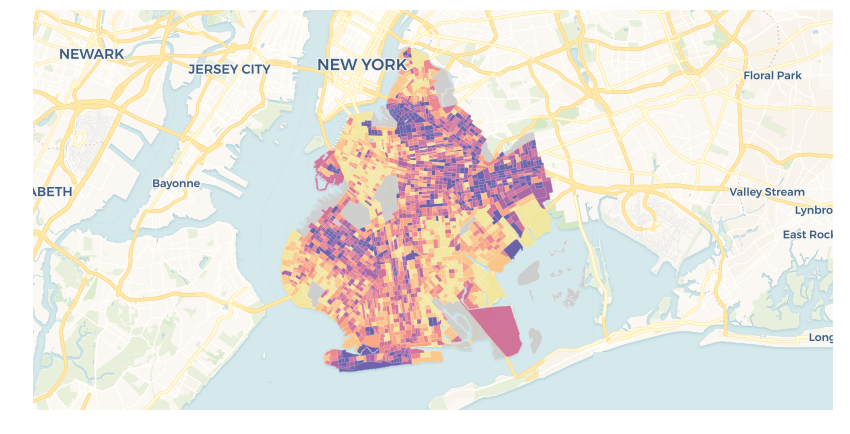

In [4]:
from cartoframes import Layer, styling, BaseMap
l = Layer('brooklyn_poverty_example',
          color={'column': 'poverty_per_pop',
                 'scheme': styling.sunset(7)})
cc.map(layers=l,
       interactive=False)

### Multiple variables together

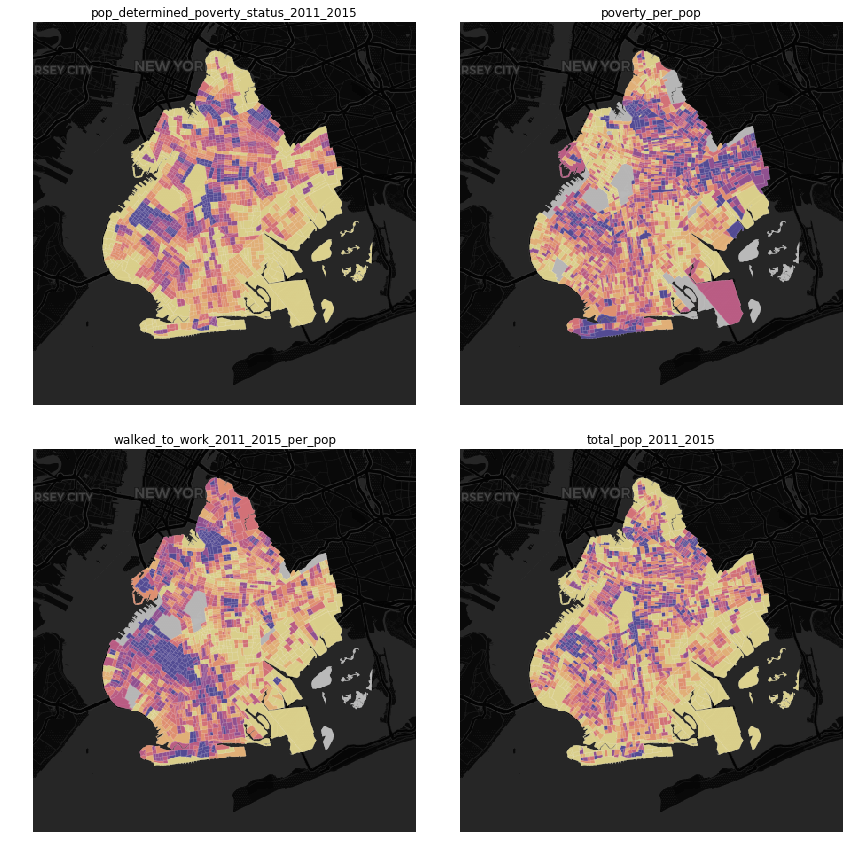

In [5]:
table = 'brooklyn_poverty_example'
cols = [
    'pop_determined_poverty_status_2011_2015',
    'poverty_per_pop',
    'walked_to_work_2011_2015_per_pop',
    'total_pop_2011_2015'
]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for idx, col in enumerate(cols):
    cc.map(layers=[BaseMap('dark'), Layer(table,
                        color={'column': col,
                               'scheme': styling.sunset(7, 'quantiles')})],
           ax=axs[idx // 2][idx % 2],
           zoom=11, lng=-73.9476, lat=40.6437,
           interactive=False,
           size=(432, 432))
    axs[idx // 2][idx % 2].set_title(col)
fig.tight_layout()
plt.show()

## NYC Taxi Dataset

Let's explore a typical `cartoframes` workflow using data on NYC taxis.

To get the data into CARTO, we can:
1. Use `pandas` to grab the data from the cartoframes example account
2. Send it to your CARTO account using `cc.write`, specifying the `lng`/`lat` columns you want to use for visualization
3. Set `overwrite=True` to replace an existing dataset if it exists
4. Refresh our `df` with the CARTO-fied version using `cc.read``

In [6]:
# read in a CSV of NYC taxi data from cartoframes example datasets
from cartoframes.examples import read_taxi
df = read_taxi()

# show first five rows to see what we've got
df.head()

,dropoff_latitude,dropoff_longitude,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_longitude,ratecodeid,store_and_fwd_flag,the_geom,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid
cartodb_id,,,,,,,,,,,,,,,,,,,,
1,40.706779,-74.012383,0.0,8.5,0.3,0.5,2,1,40.730461,-74.006706,1,False,None,1.00,0.0,10.30,2016-05-01 15:00:36,2016-05-01 14:52:11,2.08,2
2,40.762779,-73.973824,0.0,13.5,0.3,0.5,1,1,40.744125,-73.924957,1,False,None,2.00,0.0,16.30,2016-05-01 08:49:02,2016-05-01 08:34:08,3.00,1
3,40.740833,-73.998955,0.0,14.5,0.3,0.5,1,2,40.748501,-73.973488,1,False,None,0.00,0.0,15.30,2016-05-04 10:07:09,2016-05-04 09:44:40,2.10,1
4,40.792370,-73.966362,0.5,15.0,0.3,0.5,1,2,40.743267,-73.999786,1,False,None,0.00,0.0,16.30,2016-05-01 21:05:24,2016-05-01 20:50:11,4.41,2
5,40.784939,-73.956963,0.0,19.5,0.3,0.5,2,1,40.803360,-73.963631,1,False,None,4.06,0.0,24.36,2016-05-02 07:53:53,2016-05-02 07:26:56,4.01,2


In [7]:
# send it to carto so we can map it
# specify the columns we want to have as a point (pickup location)
cc.write(df, 'taxi_50k',
         lnglat=('pickup_longitude', 'pickup_latitude'),
         overwrite=True)

# read the fresh carto-fied version
df = cc.read('taxi_50k')

Table successfully written to CARTO: https://eschbacher.carto.com/dataset/taxi_50k
`the_geom` column is being populated from `('pickup_longitude', 'pickup_latitude')`. Check the status of the operation with:
    BatchJobStatus(CartoContext(), '787ce294-3fce-47d0-8390-5599c4fc35c8').status()
or try reading the table from CARTO in a couple of minutes.
Note: `CartoContext.map` will not work on this table until its geometries are created.


Take a look at the data on a map.

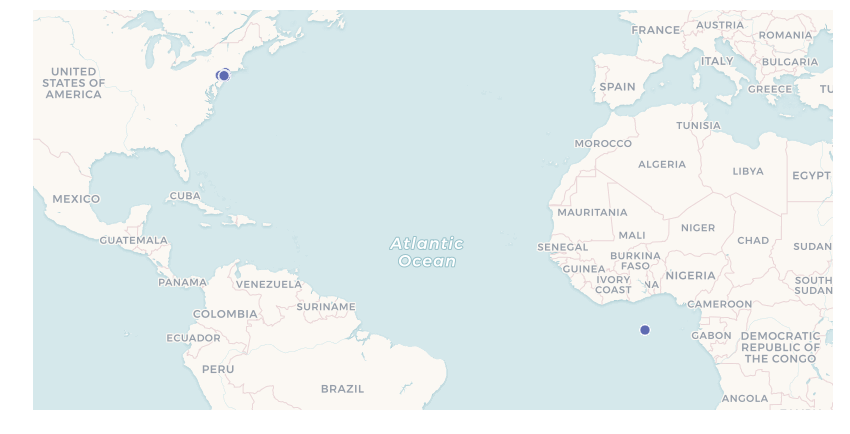

In [8]:
from cartoframes import Layer
cc.map(layers=Layer('taxi_50k'),
       interactive=False)

Oops, there are some zero-valued long/lats in there, so the results are going to [null island](https://en.wikipedia.org/wiki/Null_Island). Let's remove them.

In [9]:
# select only the rows which are not at (0,0)
df = df[(df['pickup_longitude'] != 0) | (df['pickup_latitude'] != 0)]
# send back up to CARTO
cc.write(df, 'taxi_50k', overwrite=True,
         lnglat=('pickup_longitude', 'pickup_latitude'))

Table successfully written to CARTO: https://eschbacher.carto.com/dataset/taxi_50k
`the_geom` column is being populated from `('pickup_longitude', 'pickup_latitude')`. Check the status of the operation with:
    BatchJobStatus(CartoContext(), '292c4b72-965a-4b17-970c-8527b85eced4').status()
or try reading the table from CARTO in a couple of minutes.
Note: `CartoContext.map` will not work on this table until its geometries are created.


BatchJobStatus(job_id='292c4b72-965a-4b17-970c-8527b85eced4', last_status='pending', created_at='2018-06-26T13:47:06.959Z')

Instead of using pandas, we could have remove those rows on the database by using SQL.

```python
cc.query('''
DELETE FROM taxi_50k
WHERE pickup_longitude = 0 and pickup_latitude = 0
''')
```

In [10]:
# Let's take a look at what's going on, styled by the fare amount
cc.map(layers=Layer('taxi_50k',
                    size=4,
                    color={'column': 'fare_amount',
                           'scheme': styling.sunset(7)}),
       interactive=True)

We can use the `zoom=..., lng=..., lat=...` information in the embedded interactive map to help us get static snapshots of the regions we're interested in. For example, JFK airport is around `zoom=12, lng=-73.7880, lat=40.6629`. We can paste that information as arguments in `cc.map` to generate a static snapshot of the data there.

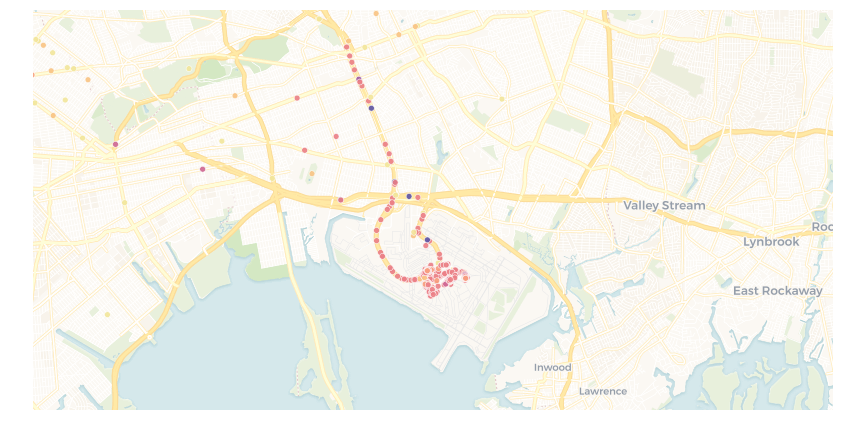

In [11]:
# Let's take a look at what's going on at JFK airport, styled by the fare amount, and STATIC
cc.map(layers=Layer('taxi_50k',
                    size=6,
                    color={'column': 'fare_amount',
                           'scheme': styling.sunset(7)}),
       zoom=12, lng=-73.7880, lat=40.6629,
       interactive=False)